# <font color='#31708f'><center>Zendesk Tickets Topic Modeling</center></font>

In [ ]:
pwd

In [ ]:
import glob

file_list = sorted(glob.glob('/home/smsta/Desktop/zendesk_tag_cloud/newman/*.json'))
for filename in file_list:
    print(filename)

In [ ]:
import ijson

def parse_json(json_filename):
        with open(filename, 'r', encoding="utf8") as file:
            # load json iteratively
            parser = ijson.parse(file)
            for prefix, event, value in parser:
                print('prefix={}, event={}, value={}'.format(prefix, event, value))
    
if __name__ == '__main__':
    parse_json(filename)

In [ ]:
import re
from string import punctuation

def extract_ticket_text_generator(json_filename):
    """This function takes a list of files with tickets and extracts text from each ticket. The result is a list of text strings."""
    for filename in file_list:
            with open(filename, 'r', encoding="utf8") as input_file:
                # Extract specific items from the file
                tickets = ijson.items(input_file, 'run.executions.item.assertions.item.assertion')
                for ticket in tickets:
                    # Extract the substring between two markers
                    l = re.findall('plain_body(.+?)public', ticket)
                    #Remove escaped newline '\\n' and non-breaking space 'nbsp' characters
                    m = [re.sub(r'\\n|nbsp', ' ', t) for t in l]
                    # Remove any URL within a string
                    p = [re.sub(r'http\S+|www\S+', '', o) for o in m]          
                    # Remove all of the punctuation in any item in the list. The result is for each ticket a list of comments.
                    q = [''.join(c for c in s if c not in punctuation) for s in p]
                    # Join list elements without any separator. The result is for each ticket a list of merged comments.
                    r = [' '.join(q)] 
                    yield(r)
                
    if __name__ == '__main__':
        extract_ticket_text_generator(filename)

In [ ]:
def create_txt_files():
        """This function takes a list of text strings and saves each ticket in a .txt file."""
        data = extract_ticket_text_generator(filename)
        # Make a flat list out of list of lists.
        flat_list = [item for sublist in data for item in sublist]
        for i in range(len(flat_list)):
            with open("ticket_%d.txt" % (i+1), 'w', encoding="utf-8") as f:
                f.write(flat_list[i])

In [ ]:
create_txt_files()

In [1]:
from pathlib import Path

all_txt_files =[]
#control order of results from iterator
for file in sorted(Path("zendesk_txt").iterdir()):
    all_txt_files.append(file.name)
print(all_txt_files[:6])
    # counts the length of the list
len(all_txt_files)

['ticket_1.txt', 'ticket_10.txt', 'ticket_100.txt', 'ticket_1000.txt', 'ticket_10000.txt', 'ticket_10001.txt']


59046

In [2]:
import natsort 

#sort filenames in directory ascending
all_txt_files_sorted = natsort.natsorted(all_txt_files)
all_txt_files_sorted[:6]

['ticket_1.txt',
 'ticket_2.txt',
 'ticket_3.txt',
 'ticket_4.txt',
 'ticket_5.txt',
 'ticket_6.txt']

In [3]:
cd zendesk_txt

/home/smsta/Desktop/zendesk_tag_cloud/zendesk_txt


In [4]:
all_docs = []
for txt_file in all_txt_files_sorted:
    with open(txt_file, encoding="utf-8") as f:
        txt_file_as_string = f.read()
        all_docs.append(txt_file_as_string)
all_docs[:6]

['This is the first comment Feel free to delete this sample ticket This is a private comment visible to agents only that you added You also changed the ticket priority to High You can view a tickets complete history by selecting the Events link in the ticket This is the latest comment for this ticket You also changed the ticket status to Pending A Pivotal Tracker story has been created for this Ticket  Jeremy Ward added a comment in Pivotal Tracker   Adding a comment in Pivotal as an activity   View this Pivotal Tracker story  Adding comment in Zendesk  1709 Jeremy Ward changed story state to started in Pivotal Tracker   View this Pivotal Tracker story  Lynda Brown added a comment in Pivotal Tracker   The little dog jumped over the fence to see the big fat cat drinking the cream   View this Pivotal Tracker story  Jeremy Ward deleted the linked story in Pivotal Tracker As discussed add the dependency',
 'Hopefully as I set it up to do so Im closing this as it will only go to SF when the

# <font color='#576675'>Tokenize and Clean-up using gensim’s simple_preprocess()</font>

In [5]:
import gensim

data = all_docs #CHANGE

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

/home/smsta/anaconda3/envs/testenv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[['this', 'is', 'the', 'first', 'comment', 'feel', 'free', 'to', 'delete', 'this', 'sample', 'ticket', 'this', 'is', 'private', 'comment', 'visible', 'to', 'agents', 'only', 'that', 'you', 'added', 'you', 'also', 'changed', 'the', 'ticket', 'priority', 'to', 'high', 'you', 'can', 'view', 'tickets', 'complete', 'history', 'by', 'selecting', 'the', 'events', 'link', 'in', 'the', 'ticket', 'this', 'is', 'the', 'latest', 'comment', 'for', 'this', 'ticket', 'you', 'also', 'changed', 'the', 'ticket', 'status', 'to', 'pending', 'pivotal', 'tracker', 'story', 'has', 'been', 'created', 'for', 'this', 'ticket', 'jeremy', 'ward', 'added', 'comment', 'in', 'pivotal', 'tracker', 'adding', 'comment', 'in', 'pivotal', 'as', 'an', 'activity', 'view', 'this', 'pivotal', 'tracker', 'story', 'adding', 'comment', 'in', 'zendesk', 'jeremy', 'ward', 'changed', 'story', 'state', 'to', 'started', 'in', 'pivotal', 'tracker', 'view', 'this', 'pivotal', 'tracker', 'story', 'lynda', 'brown', 'added', 'comment', '

# <font color='#576675'>Lemmatization</font>

In [6]:
import spacy

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['first comment feel free delete sample ticket private comment visible agent only add also change ticket priority high can view ticket complete history select event link ticket late comment ticket also change ticket status pende pivotal tracker story create ticket add comment pivotal tracker add comment pivotal activity view pivotal tracker story add comment change story state start pivotal tracker view pivotal story add comment pivotal tracker little dog jump fence see big fat cat drink cream view pivotal story delete link story pivotal tracker discuss add dependency', 'hopefully as set so be close will only go when ticket solve']


Extracting tf-idf features for NMF...
done in 7.667s.
Extracting tf features for LDA...
done in 7.590s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


/home/smsta/anaconda3/envs/testenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/smsta/anaconda3/envs/testenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


done in 19.357s.


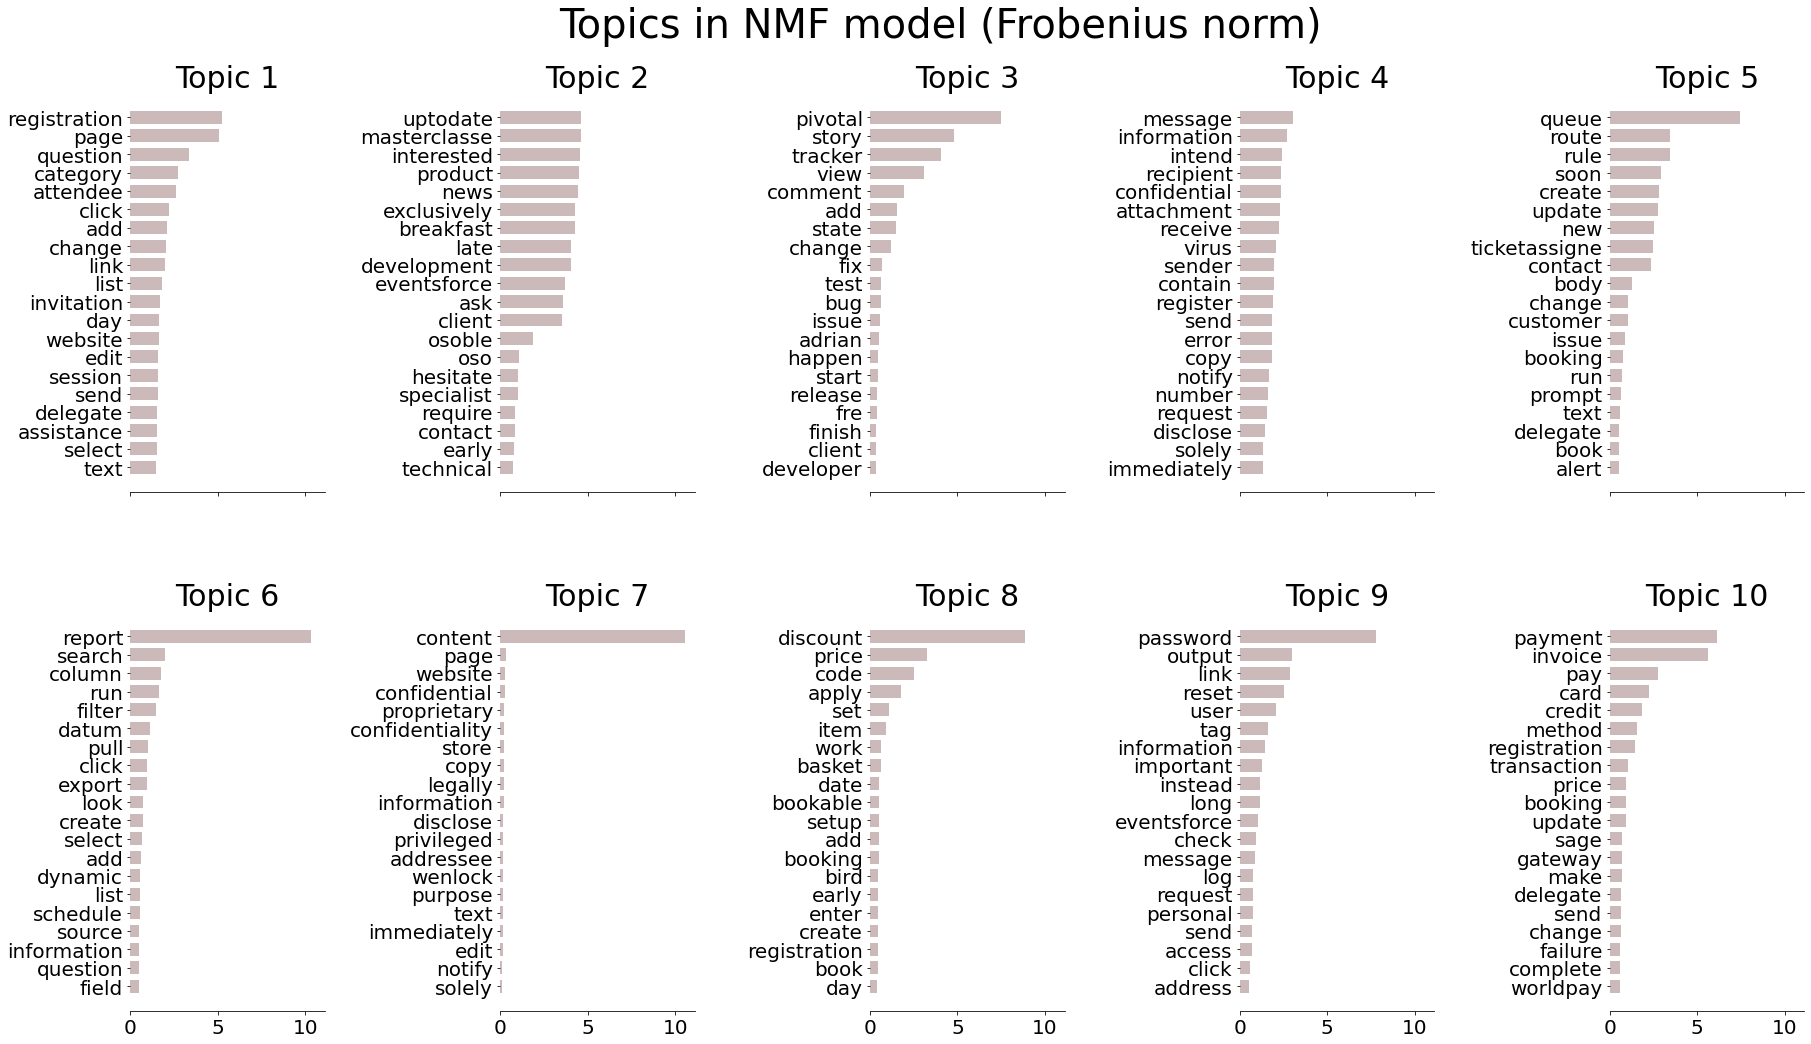



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/home/smsta/anaconda3/envs/testenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


done in 59.982s.


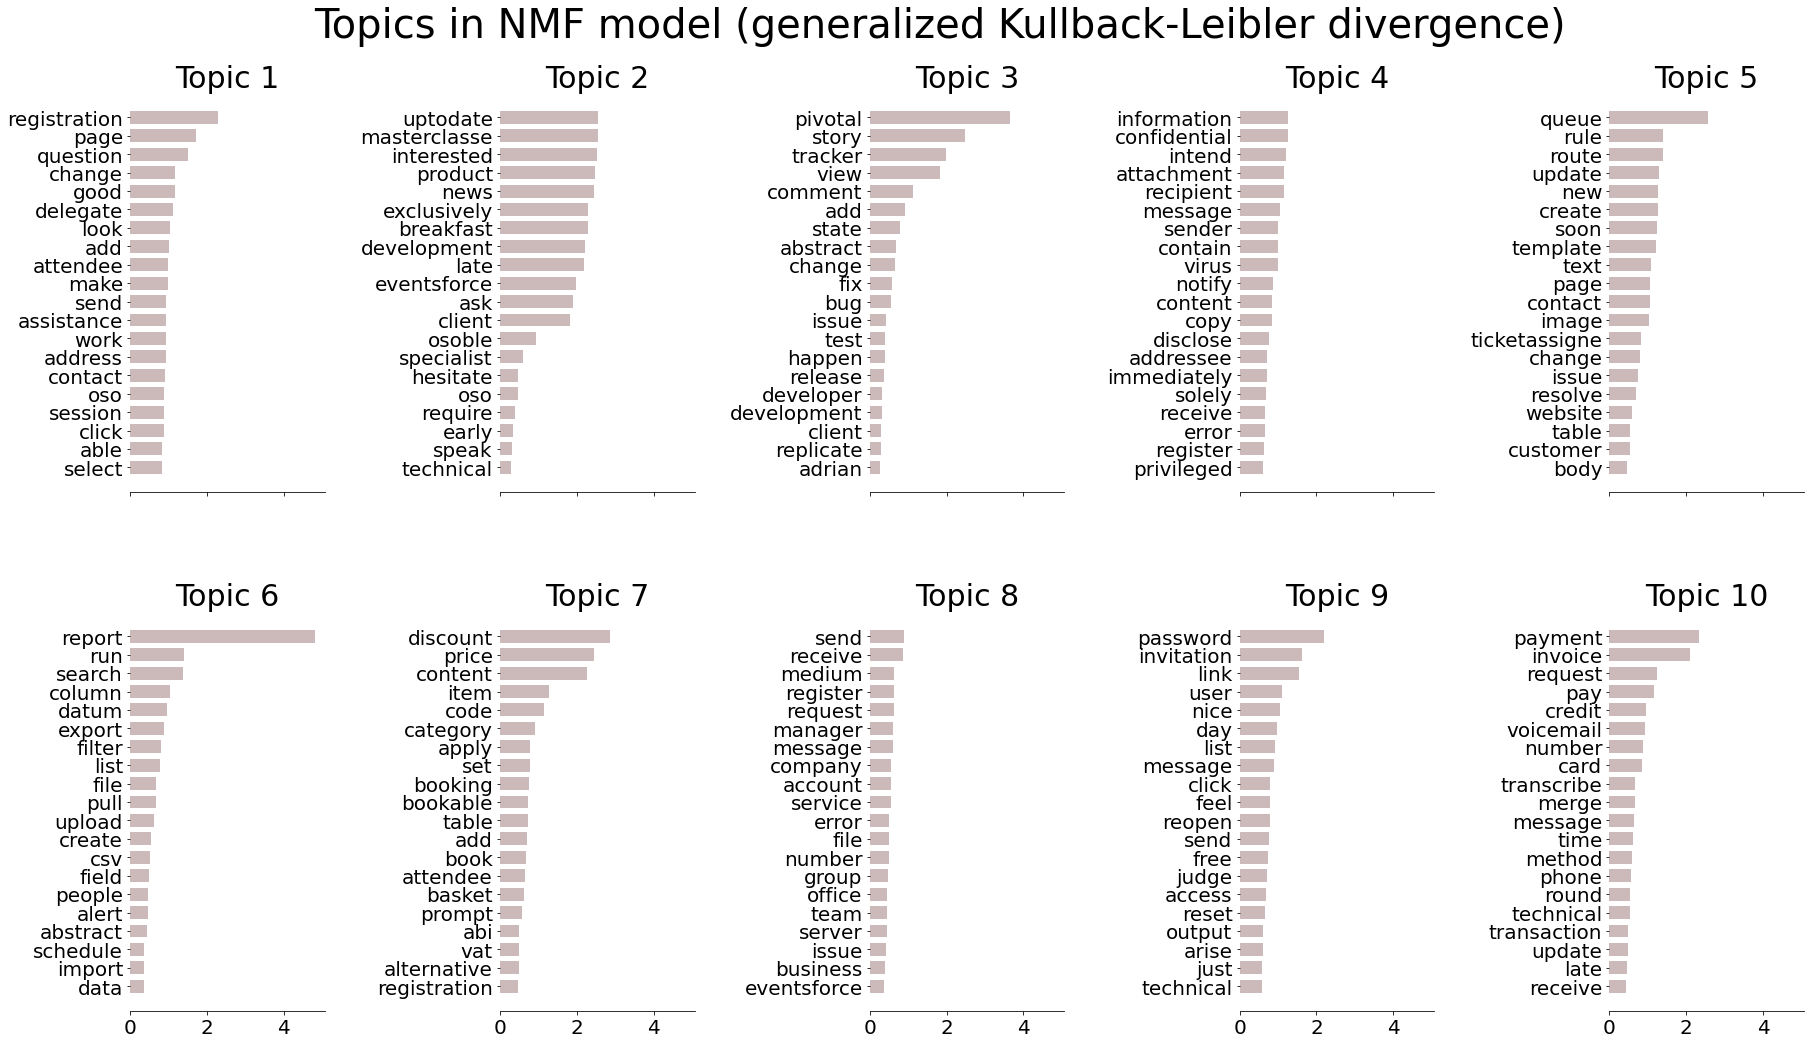



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 246.529s.


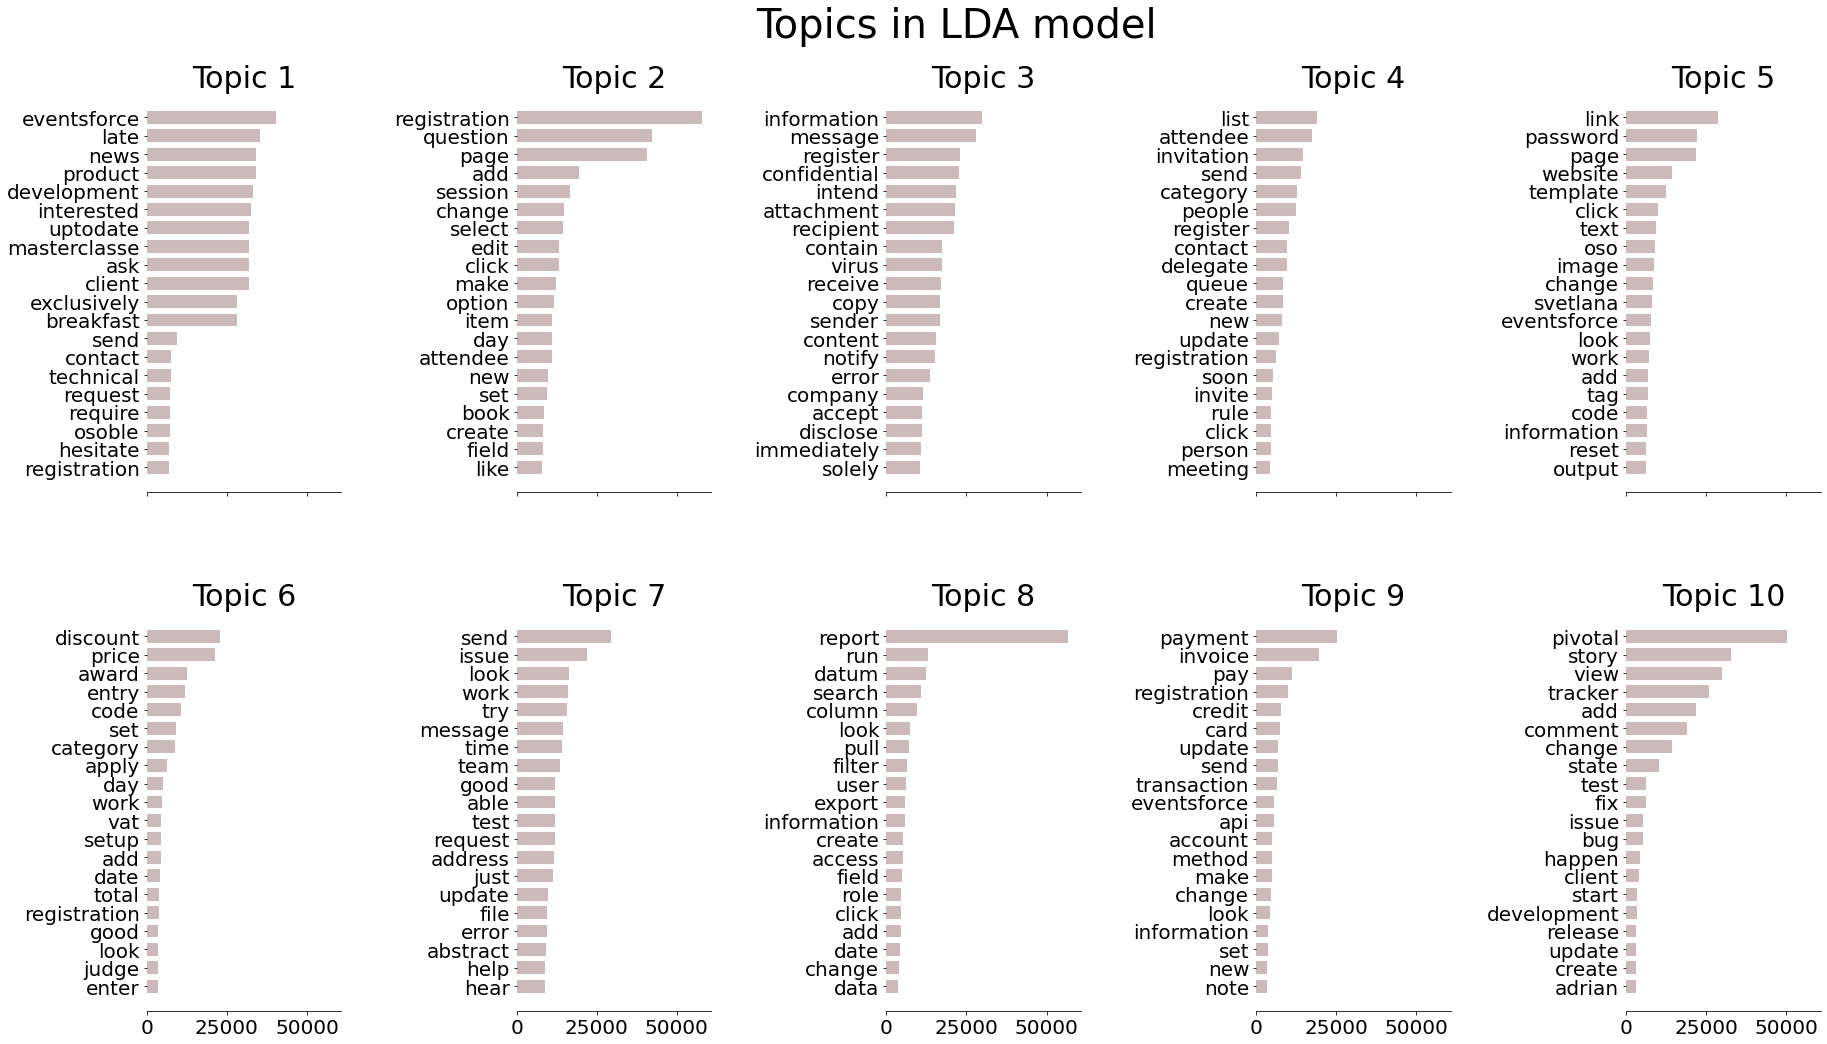

In [7]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
data_samples = data_lemmatized #CHANGE
learning_decay = 0.9   #CHANGE based on 'How to GridSearch the best LDA model'

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, 
                weights, 
                height=0.7, 
                color="#ccbaba")   #CHANGE additional
        
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    plt.show()
   
    


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

#print("Loading dataset...")
#t0 = time()
#data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
#                             remove=('headers', 'footers', 'quotes'),
#                             return_X_y=True)
#data_samples = data[:n_samples]
#print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.40,   #CHANGE from 0.95
                                   min_df=2,   
                                   max_features=n_features,
                                   stop_words='english')   
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.40,   #CHANGE from 0.95
                                min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,  
                                learning_method='online',
                                learning_offset=50.,
                                random_state=100,    #CHANGE from 0
                                learning_decay = learning_decay, #CHANGE additional based GridSearch best LDA model
                                )   
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

Save figure of only Topics in NMF model (Frobenius norm):

Extracting tf-idf features for NMF...
done in 7.633s.
Extracting tf features for LDA...
done in 7.561s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


/home/smsta/anaconda3/envs/testenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


done in 18.182s.


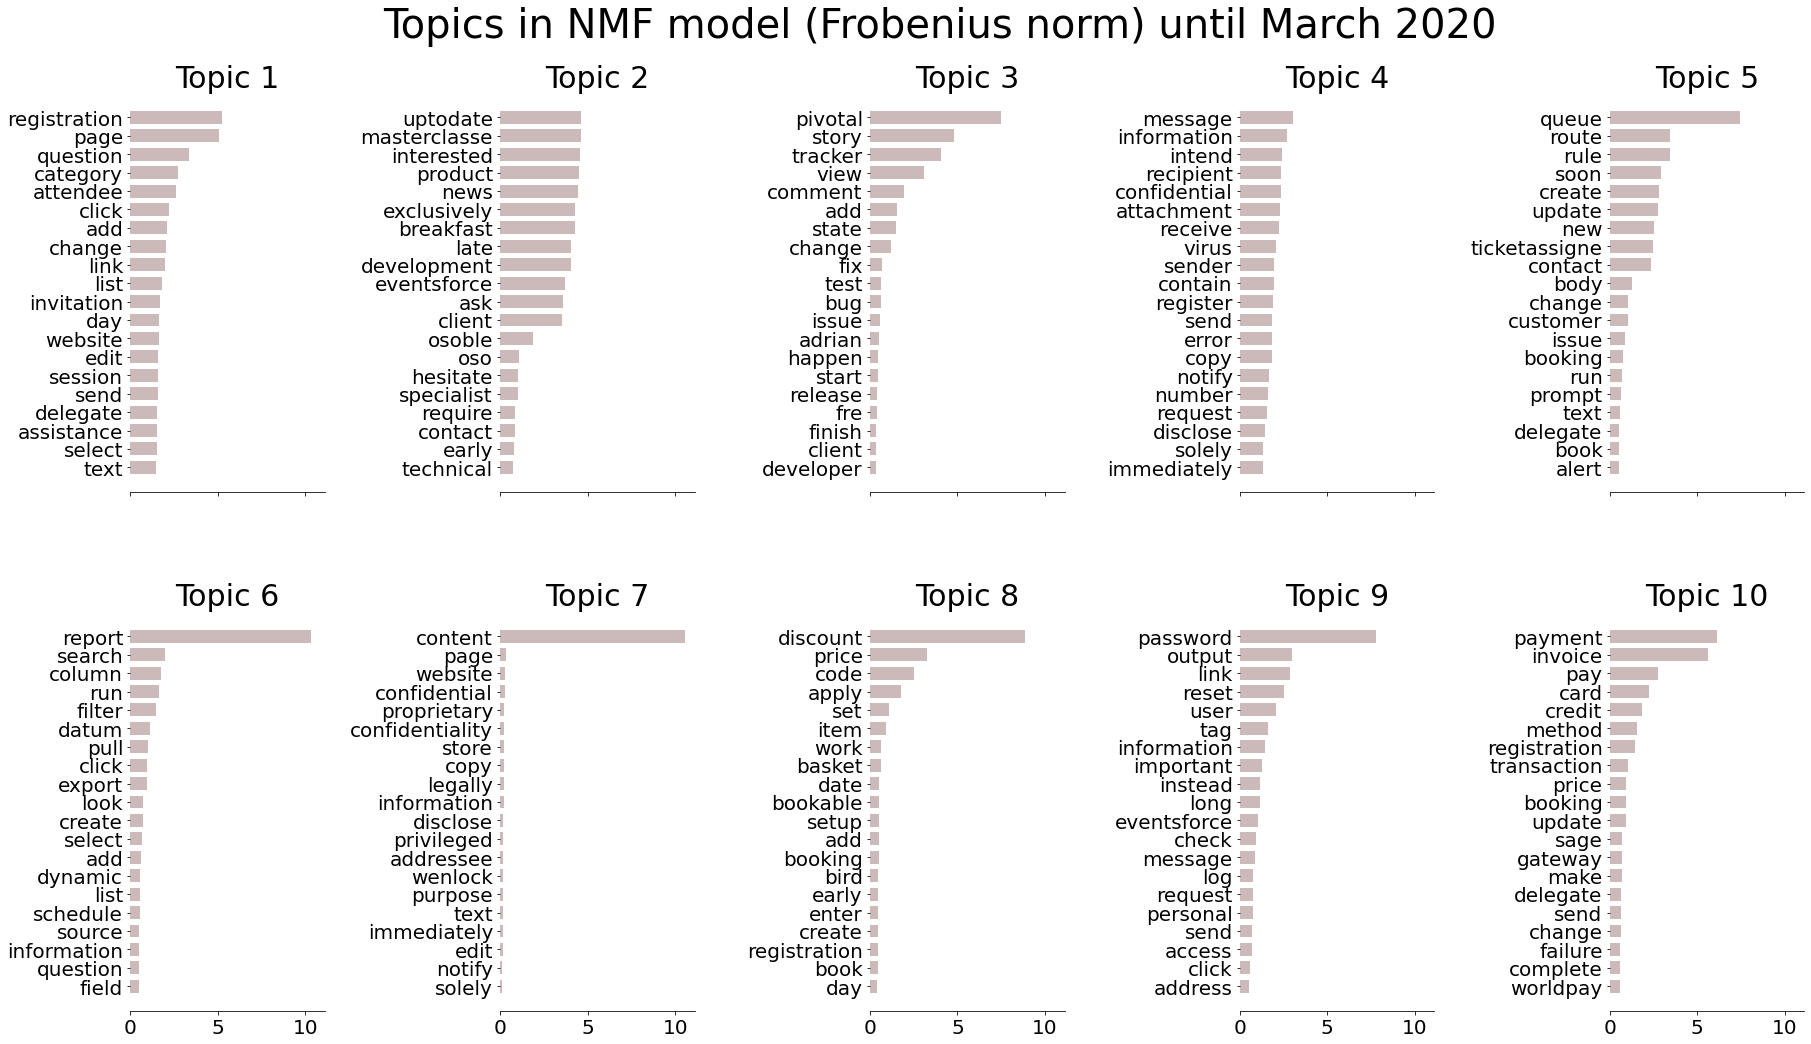

In [8]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
data_samples = data_lemmatized #CHANGE
learning_decay = 0.9   #CHANGE based on 'How to GridSearch the best LDA model'

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30,15), sharex=True)  
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, 
                weights, 
                height=0.7, 
                color="#ccbaba")   #CHANGE additional
        
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        
        fig = ax.get_figure()   #CHANGE additional
        fig.patch.set_facecolor('#FFFFFF')   #CHANGE additional
        fig.savefig("nmf_frobenius", facecolor=fig.get_facecolor())   #CHANGE additional

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    plt.show()
   
    


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

#print("Loading dataset...")
#t0 = time()
#data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
#                             remove=('headers', 'footers', 'quotes'),
#                             return_X_y=True)
#data_samples = data[:n_samples]
#print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.40,   #CHANGE from 0.95
                                   min_df=2,   
                                   max_features=n_features,
                                   stop_words='english')   
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.40,   #CHANGE from 0.95
                                min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words, 'Topics in NMF model (Frobenius norm) until March 2020') #CHANGE title

Save figure of only Topics in LDA model:

Extracting tf-idf features for NMF...
done in 7.791s.
Extracting tf features for LDA...
done in 7.770s.



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 249.856s.


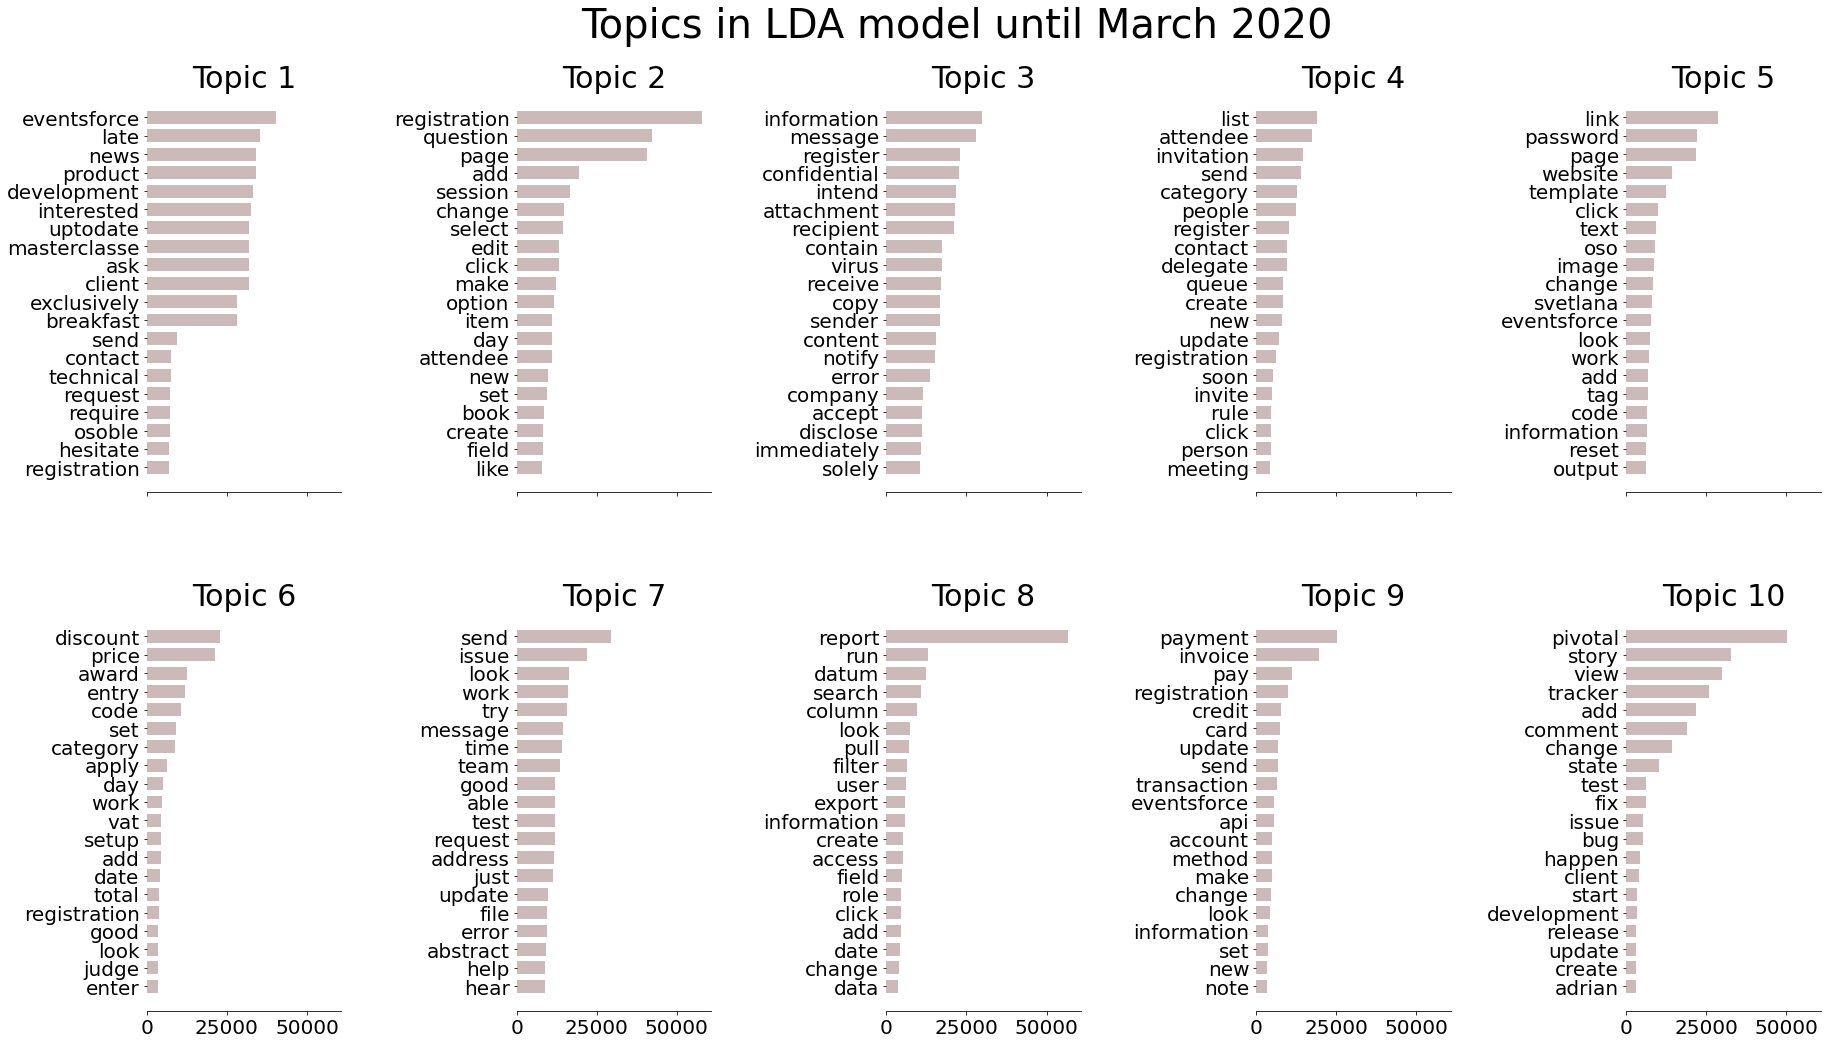

In [9]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
data_samples = data_lemmatized #CHANGE
learning_decay = 0.9   #CHANGE based on 'How to GridSearch the best LDA model'

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, 
                weights, 
                height=0.7, 
                color="#ccbaba")   #CHANGE additional
        
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        
        fig = ax.get_figure()   #CHANGE additional
        fig.patch.set_facecolor('#FFFFFF')   #CHANGE additional
        fig.savefig("lda", facecolor=fig.get_facecolor())   #CHANGE additional

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    plt.show()
   
    


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

#print("Loading dataset...")
#t0 = time()
#data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
#                             remove=('headers', 'footers', 'quotes'),
#                             return_X_y=True)
#data_samples = data[:n_samples]
#print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.40,   #CHANGE from 0.95
                                   min_df=2,   
                                   max_features=n_features,
                                   stop_words='english')   
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.40,   #CHANGE from 0.95
                                min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,  
                                learning_method='online',
                                learning_offset=50.,
                                random_state=100,    #CHANGE from 0
                                learning_decay = learning_decay, #CHANGE additional based GridSearch best LDA model
                                )   
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model until March 2020')